In [1]:
import pandas as pd
import nltk
import string
import re
import matplotlib.pyplot as plt
import demoji



from time import sleep
from tqdm import tqdm
from selenium import webdriver
from selenium.webdriver.chrome.options import Options as op
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import NoSuchElementException
from selenium.webdriver.common.keys import Keys
from nltk.sentiment import SentimentIntensityAnalyzer, 
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from wordcloud import WordCloud
from selenium.common.exceptions import NoSuchElementException, WebDriverException

In [2]:
# nltk.download('stopwords')
# nltk.download('punkt')
# nltk.download('snowball_data')
# demoji.download_codes()

In [3]:

stop_words = set(stopwords.words('english'))
stemmer = SnowballStemmer('english')


In [4]:

def search(query: str):
    options = op()
    options.add_argument("--headless") 
    options.add_argument('user-agent=Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/112.0.0.0 Safari/537.36')
    driver = webdriver.Chrome(options=options)

    # Navigate to Google
    driver.get("https://www.google.com")

    # Wait for the search box to be visible
    wait = WebDriverWait(driver, 10)
    search_box = wait.until(EC.visibility_of_element_located((By.NAME, "q")))

    # Enter the query and submit
    search_box.send_keys(f"{query} review site: youtube.com")
    search_box.send_keys(Keys.RETURN)

    # Wait for the page to load
    driver.implicitly_wait(5)

    # Get the top 5 links
    links = driver.find_elements(By.XPATH, "//div[@class='ct3b9e']//a")
    urls = [link.get_attribute("href") for link in links[:10]]

    driver.quit()
    
    return urls


In [5]:
def getComments(url):
    
    # Set up Chrome driver options
    chrome_options =op()
    chrome_options.add_argument("--headless")
    chrome_options.add_argument("--disable-extensions")
    chrome_options.add_argument("--disable-gpu")
    chrome_options.add_argument("--no-sandbox")
    # Initialize ChromeDriver with an implicit wait of 10 seconds
    driver = webdriver.Chrome(options=chrome_options)
    driver.implicitly_wait(20)

    # Open the video page
    driver.get(url)
    sleep(15)

    # Wait for the comment section to load
    wait = WebDriverWait(driver, 20)
    wait.until(EC.presence_of_element_located((By.XPATH, '//*[@id="continuations"]')))

    SCROLL_PAUSE_TIME = 14
    last_height = driver.execute_script("return document.documentElement.scrollHeight")
    scrolls = 0
    while True:
        driver.execute_script("window.scrollTo(0, document.documentElement.scrollHeight);")
        sleep(SCROLL_PAUSE_TIME)
        new_height = driver.execute_script("return document.documentElement.scrollHeight")
        if new_height == last_height:
            break
        last_height = new_height
        scrolls += 1
        if scrolls >= 8:
            break


    # Find the comment div element and extract the comments
    comment_list = []
    try:
        comment_div = driver.find_element(By.XPATH, '//*[@id="contents"]')
        comments = comment_div.find_elements(By.XPATH, '//*[@id="content-text"]')
        for comment in comments:
            comment_list.append(comment.text.strip())
    except NoSuchElementException:
        print("Could not find comment section.")
    finally:
        driver.quit()
        return comment_list


In [6]:
query = "pixel fold"
urls = search(query)

In [7]:
comments = []
for url in tqdm(urls):
    sleep(10)
    com = getComments(url)
    comments.extend(com)
    
    

 80%|█████████████████████████████████████████████████████████████████▌                | 8/10 [17:37<04:24, 132.16s/it]


WebDriverException: Message: unknown error: net::ERR_NAME_NOT_RESOLVED
  (Session info: headless chrome=113.0.5672.93)
Stacktrace:
Backtrace:
	GetHandleVerifier [0x00B5DCE3+50899]
	(No symbol) [0x00AEE111]
	(No symbol) [0x009F5588]
	(No symbol) [0x009F1D87]
	(No symbol) [0x009E8B45]
	(No symbol) [0x009E9B1A]
	(No symbol) [0x009E8E20]
	(No symbol) [0x009E8275]
	(No symbol) [0x009E820C]
	(No symbol) [0x009E6F06]
	(No symbol) [0x009E7668]
	(No symbol) [0x009F6D22]
	(No symbol) [0x00A4E631]
	(No symbol) [0x00A3B8FC]
	(No symbol) [0x00A4E01C]
	(No symbol) [0x00A3B6F6]
	(No symbol) [0x00A17708]
	(No symbol) [0x00A1886D]
	GetHandleVerifier [0x00DC3EAE+2566302]
	GetHandleVerifier [0x00DF92B1+2784417]
	GetHandleVerifier [0x00DF327C+2759788]
	GetHandleVerifier [0x00BF5740+672048]
	(No symbol) [0x00AF8872]
	(No symbol) [0x00AF41C8]
	(No symbol) [0x00AF42AB]
	(No symbol) [0x00AE71B7]
	BaseThreadInitThunk [0x75CD00F9+25]
	RtlGetAppContainerNamedObjectPath [0x77187BBE+286]
	RtlGetAppContainerNamedObjectPath [0x77187B8E+238]


In [81]:
df = pd.DataFrame({'comments':comments})

In [82]:
# df.to_csv(f'{query}_comments.csv', index = False)

In [83]:
# df = pd.read_csv('comments.csv')

In [84]:
# def clean_text(text, device_name = query):
#     # Convert text to lowercase
#     text = text.lower()

#     # Remove device name
#     device_name = device_name.lower()
#     device_name_terms = [term.strip() for term in device_name.split()]
#     device_name_regex = '|'.join(device_name_terms)
#     text = re.sub(device_name_regex, '', text)

#     # Remove terms related to device
#     remove_terms = ['phone', 'review', 'display', 'use', 'upgrade', 'screen', 'battery', 'year', 'video', 'watch', 'note', 'life', 'google', 'abl','galaxy'] + device_name_terms
#     remove_terms_regex = '|'.join(remove_terms)
#     text = re.sub(remove_terms_regex, '', text)

#     # Remove punctuation marks
#     text = text.translate(str.maketrans('', '', string.punctuation))

#     # Remove numbers and special characters
#     text = re.sub('[^a-zA-Z ]', '', text)

#     # Remove URLs and mentions
#     text = re.sub(r'http\S+', '', text)
#     text = re.sub('@[^\s]+', '', text)

#     # Remove emojis
#     text = remove_emojis(text)

#     # Tokenize the text into words
#     words = word_tokenize(text)

#     # Remove stop words
#     words = [word for word in words if word not in stop_words]

#     # Stem the words
#     words = [stemmer.stem(word) for word in words]

#     # Join the words back into a string
#     text = ' '.join(words)

#     return text

# def remove_emojis(text):
#     return demoji.replace(text, '')


In [85]:
import re
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk import pos_tag
import demoji

def clean_text(text, device_name=query):
    # Convert text to lowercase
    text = text.lower()

    # Remove device name
    device_name = device_name.lower()
    device_name_terms = [term.strip() for term in device_name.split()]
    device_name_regex = '|'.join(device_name_terms)
    text = re.sub(device_name_regex, '', text)

    # Remove terms related to device
    remove_terms = ['phone', 'review', 'display', 'use', 'upgrade', 'screen', 'battery', 'year', 'video', 'watch', 'note', 'life', 'google', 'galaxy'] + device_name_terms
    remove_terms_regex = '|'.join(remove_terms)
    text = re.sub(remove_terms_regex, '', text)

    # Remove punctuation marks
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Remove numbers and special characters
    text = re.sub('[^a-zA-Z ]', '', text)

    # Remove URLs and mentions
    text = re.sub(r'http\S+', '', text)
    text = re.sub('@[^\s]+', '', text)

    # Remove emojis
    # text = remove_emojis(text)

    # Tokenize the text into words
    words = word_tokenize(text)

    # Remove stop words and non-noun words
    stop_words = set(stopwords.words('english'))
    noun_words = []
    for word, pos in pos_tag(words):
        if word not in stop_words and pos.startswith('N'):
            noun_words.append(word)

    # Stem the words
    stemmer = SnowballStemmer('english')
    words = [stemmer.stem(word) for word in noun_words]

    # Join the words back into a string
    text = ' '.join(words)

    return text

def remove_emojis(text):
    return demoji.replace(text, '')


In [86]:
df['cleaned_comments'] = df.comments.apply(clean_text)
df['cleaned_comments'] = df.cleaned_comments.apply(remove_emojis)

In [87]:

# Create an instance of the sentiment analyzer
sid = SentimentIntensityAnalyzer()

# Apply the sentiment analyzer to each comment
df['sentiment_scores'] = df['cleaned_comments'].apply(lambda x: sid.polarity_scores(x))

# Extract the compound score from the sentiment scores
df['compound_score'] = df['sentiment_scores'].apply(lambda x: x['compound'])

# Categorize the comments as positive, negative, or neutral based on the compound score
df['sentiment_category'] = pd.cut(df['compound_score'], bins=3, labels=['negative', 'neutral', 'positive'])


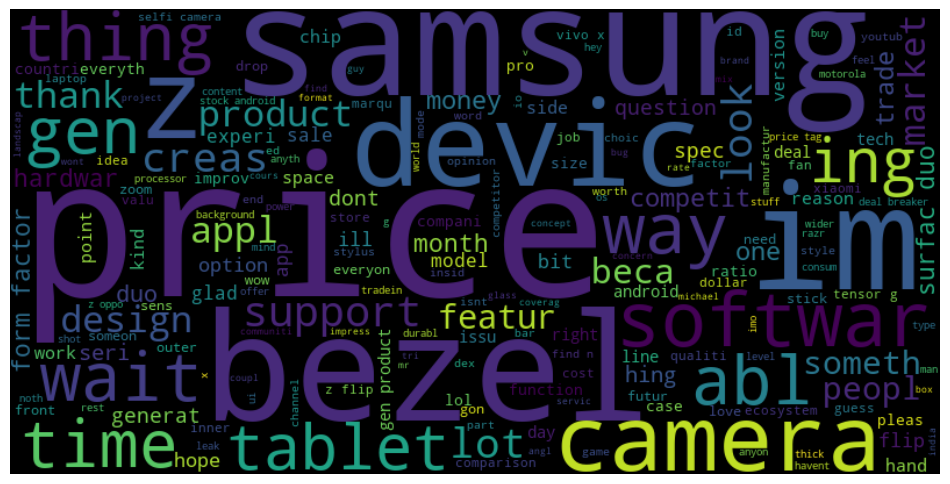

In [80]:

# Join the words in the cleaned comments to a single string
text = ' '.join(df['cleaned_comments'])

# Create a word cloud object and generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='black').generate(text)

# Plot the word cloud
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


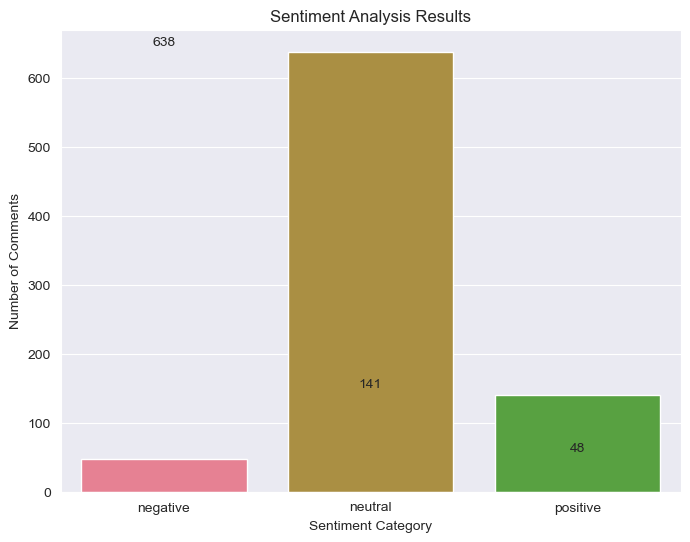

In [88]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style and color palette
sns.set_style('darkgrid')
sns.set_palette('husl')

# Get the count of comments in each sentiment category
sentiment_counts = df['sentiment_category'].value_counts()

# Plot the bar chart
fig, ax = plt.subplots(figsize=(8, 6))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, ax=ax)
ax.set_xlabel('Sentiment Category')
ax.set_ylabel('Number of Comments')
ax.set_title('Sentiment Analysis Results')

# Add labels to the bars
for i, v in enumerate(sentiment_counts.values):
    ax.text(i, v+10, str(v), ha='center')

plt.show()


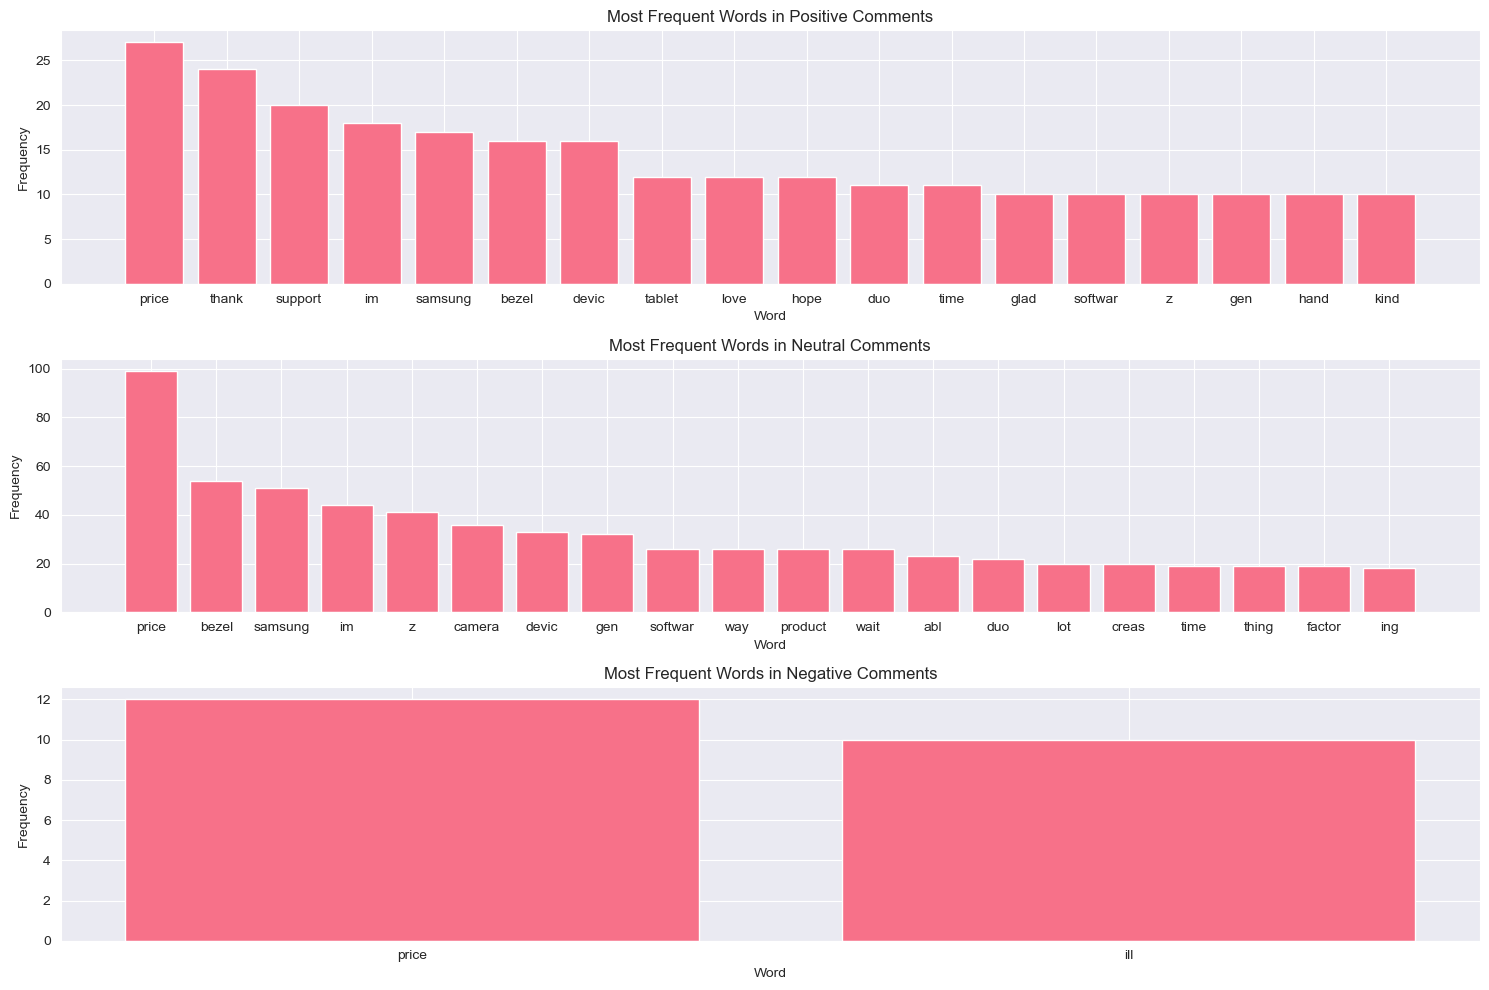

In [89]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

# Define the stop words
stop_words = set(stopwords.words('english'))

# Define the minimum word frequency threshold
min_freq = 10

# Define a function to tokenize the comments and remove stop words
def tokenize_comments(comment_series):
    # Combine the comments into a single string
    all_comments = ' '.join(comment_series.tolist())

    # Tokenize the string into words
    words = word_tokenize(all_comments)

    # Remove stop words
    filtered_words = [word for word in words if word.lower() not in stop_words]

    return filtered_words

# Create separate dataframes for each sentiment category
positive_df = df[df['sentiment_category'] == 'positive']
neutral_df = df[df['sentiment_category'] == 'neutral']
negative_df = df[df['sentiment_category'] == 'negative']

# Tokenize the comments and remove stop words for each dataframe
positive_words = tokenize_comments(positive_df['cleaned_comments'])
neutral_words = tokenize_comments(neutral_df['cleaned_comments'])
negative_words = tokenize_comments(negative_df['cleaned_comments'])

# Count the frequency of each word in each dataframe
positive_freq = nltk.FreqDist(positive_words)
neutral_freq = nltk.FreqDist(neutral_words)
negative_freq = nltk.FreqDist(negative_words)

# Remove words that appear less frequently than the minimum frequency threshold
positive_freq = {k: v for k, v in positive_freq.items() if v >= min_freq}
neutral_freq = {k: v for k, v in neutral_freq.items() if v >= min_freq}
negative_freq = {k: v for k, v in negative_freq.items() if v >= min_freq}

# Sort the dictionaries by word frequency in descending order
positive_freq = dict(sorted(positive_freq.items(), key=lambda item: item[1], reverse=True))
neutral_freq = dict(sorted(neutral_freq.items(), key=lambda item: item[1], reverse=True))
negative_freq = dict(sorted(negative_freq.items(), key=lambda item: item[1], reverse=True))

# Plot the top 20 most frequent words in each sentiment category
plt.figure(figsize=(15, 10))

plt.subplot(3, 1, 1)
plt.bar(list(positive_freq.keys())[:20], list(positive_freq.values())[:20])
plt.title('Most Frequent Words in Positive Comments')
plt.xlabel('Word')
plt.ylabel('Frequency')

plt.subplot(3, 1, 2)
plt.bar(list(neutral_freq.keys())[:20], list(neutral_freq.values())[:20])
plt.title('Most Frequent Words in Neutral Comments')
plt.xlabel('Word')
plt.ylabel('Frequency')

plt.subplot(3, 1, 3)
plt.bar(list(negative_freq.keys())[:20], list(negative_freq.values())[:20])
plt.title('Most Frequent Words in Negative Comments')
plt.xlabel('Word')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


In [90]:
from textblob import TextBlob

# Define a function to get the sentiment polarity of a comment
def get_polarity(comment):
    if isinstance(comment, str):
        return TextBlob(comment).sentiment.polarity
    else:
        return 0.0 # or whatever default polarity you want to assign to non-string inputs


# Apply the function to each comment
df['polarity_score'] = df['cleaned_comments'].apply(get_polarity)

# Categorize the comments as positive, negative, or neutral based on the polarity score
df['sentiment_category_textblob'] = pd.cut(df['polarity_score'], bins=3, labels=['negative', 'neutral', 'positive'])


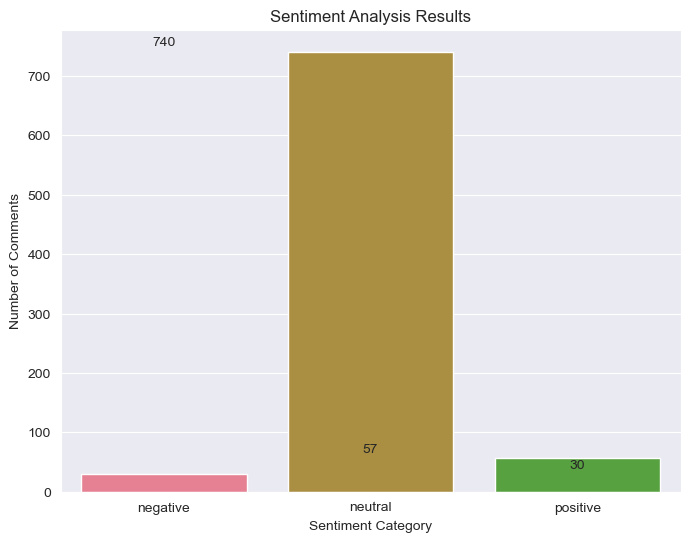

In [91]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style and color palette
sns.set_style('darkgrid')
sns.set_palette('husl')

# Get the count of comments in each sentiment category
sentiment_counts = df['sentiment_category_textblob'].value_counts()

# Plot the bar chart
fig, ax = plt.subplots(figsize=(8, 6))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, ax=ax)
ax.set_xlabel('Sentiment Category')
ax.set_ylabel('Number of Comments')
ax.set_title('Sentiment Analysis Results')

# Add labels to the bars
for i, v in enumerate(sentiment_counts.values):
    ax.text(i, v+10, str(v), ha='center')

plt.show()


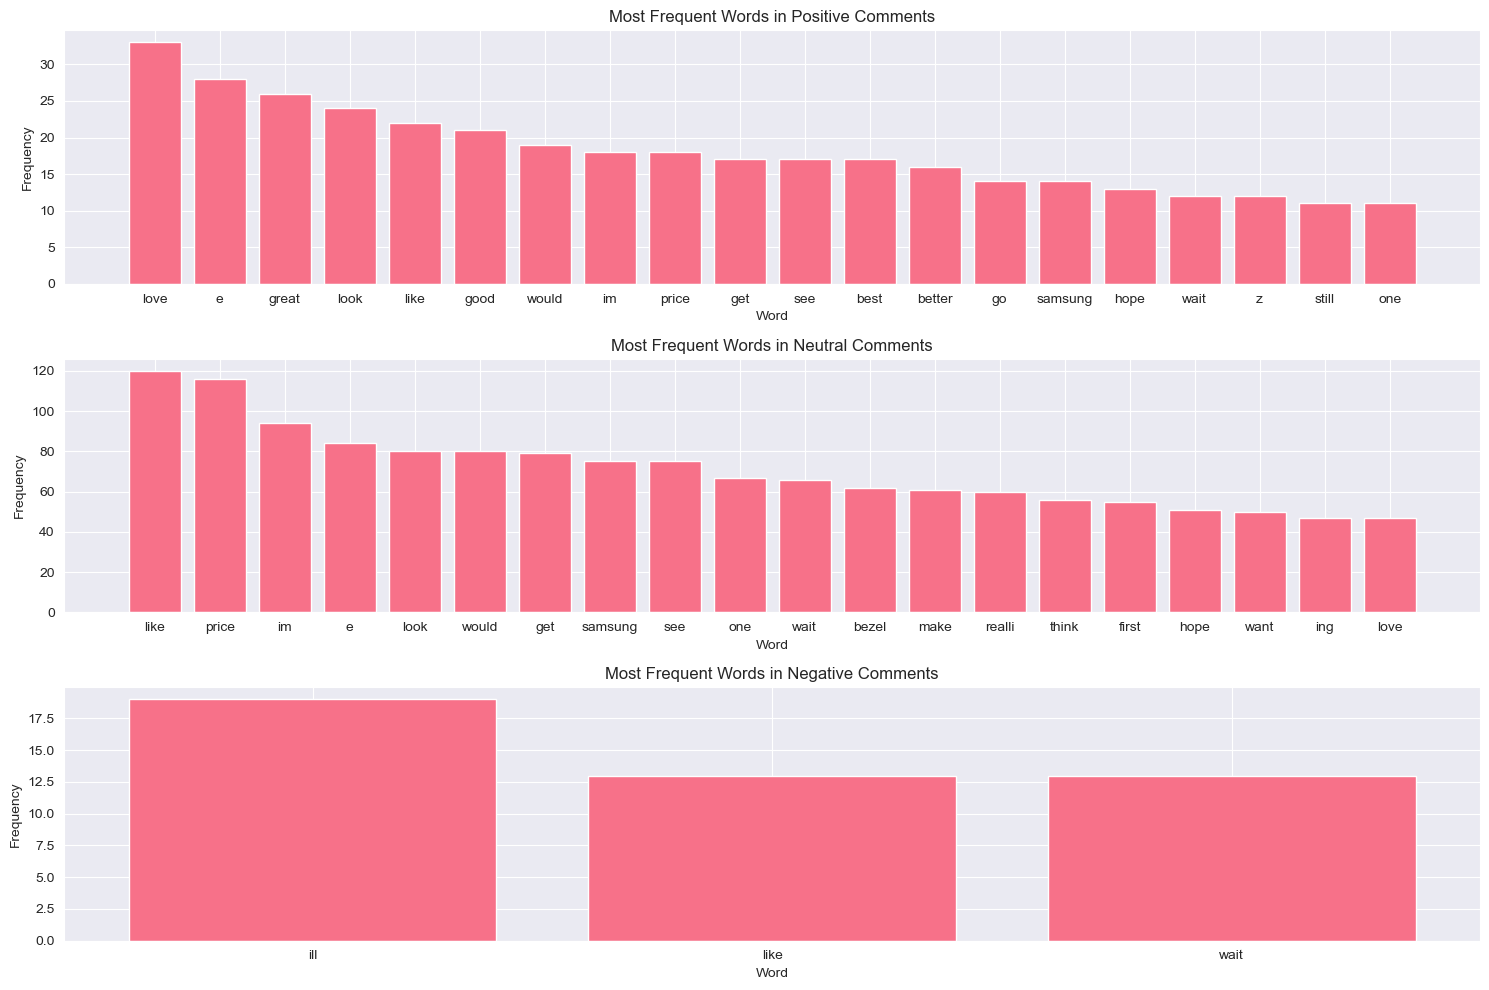

In [54]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

# Define the stop words
stop_words = set(stopwords.words('english'))

# Define the minimum word frequency threshold
min_freq = 10

# Define a function to tokenize the comments and remove stop words
def tokenize_comments(comment_series):
    # Combine the comments into a single string
    all_comments = ' '.join(comment_series.tolist())

    # Tokenize the string into words
    words = word_tokenize(all_comments)

    # Remove stop words
    filtered_words = [word for word in words if word.lower() not in stop_words]

    return filtered_words

# Create separate dataframes for each sentiment category
positive_df = df[df['sentiment_category_textblob'] == 'positive']
neutral_df = df[df['sentiment_category_textblob'] == 'neutral']
negative_df = df[df['sentiment_category_textblob'] == 'negative']

# Tokenize the comments and remove stop words for each dataframe
positive_words = tokenize_comments(positive_df['cleaned_comments'])
neutral_words = tokenize_comments(neutral_df['cleaned_comments'])
negative_words = tokenize_comments(negative_df['cleaned_comments'])

# Count the frequency of each word in each dataframe
positive_freq = nltk.FreqDist(positive_words)
neutral_freq = nltk.FreqDist(neutral_words)
negative_freq = nltk.FreqDist(negative_words)

# Remove words that appear less frequently than the minimum frequency threshold
positive_freq = {k: v for k, v in positive_freq.items() if v >= min_freq}
neutral_freq = {k: v for k, v in neutral_freq.items() if v >= min_freq}
negative_freq = {k: v for k, v in negative_freq.items() if v >= min_freq}

# Sort the dictionaries by word frequency in descending order
positive_freq = dict(sorted(positive_freq.items(), key=lambda item: item[1], reverse=True))
neutral_freq = dict(sorted(neutral_freq.items(), key=lambda item: item[1], reverse=True))
negative_freq = dict(sorted(negative_freq.items(), key=lambda item: item[1], reverse=True))

# Plot the top 20 most frequent words in each sentiment category
plt.figure(figsize=(15, 10))

plt.subplot(3, 1, 1)
plt.bar(list(positive_freq.keys())[:20], list(positive_freq.values())[:20])
plt.title('Most Frequent Words in Positive Comments')
plt.xlabel('Word')
plt.ylabel('Frequency')

plt.subplot(3, 1, 2)
plt.bar(list(neutral_freq.keys())[:20], list(neutral_freq.values())[:20])
plt.title('Most Frequent Words in Neutral Comments')
plt.xlabel('Word')
plt.ylabel('Frequency')

plt.subplot(3, 1, 3)
plt.bar(list(negative_freq.keys())[:20], list(negative_freq.values())[:20])
plt.title('Most Frequent Words in Negative Comments')
plt.xlabel('Word')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()
